--- CARGANDO DATOS Y CONFIGURANDO ---
Dataset cargado: 20 observaciones, 3 predictores, 3 respuestas.

--- PARTE 1: VISUALIZACIÓN 3D DE LOS DATOS ---


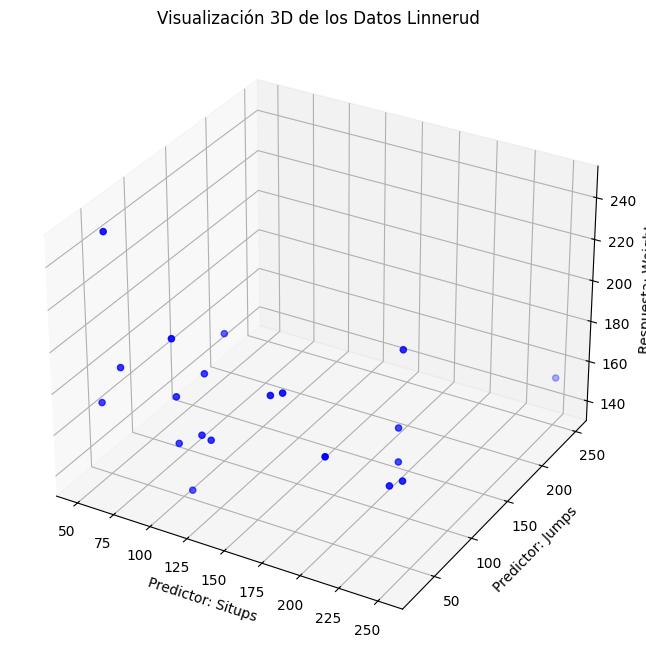


--- PARTE 2: AJUSTANDO LOS 5 MODELOS DE REGRESIÓN ---
Modelos ajustados con éxito.

--- PARTE 3: DIAGNÓSTICOS DE LOS MODELOS ---

Tabla de Distancias - Modelo Clásico:
    d(x)  d(r_residuals)
0 1.5122          1.1555
1 1.5554          0.6787
2 2.0598          0.7596
3 1.4970          1.5763
4 0.9481          1.6642


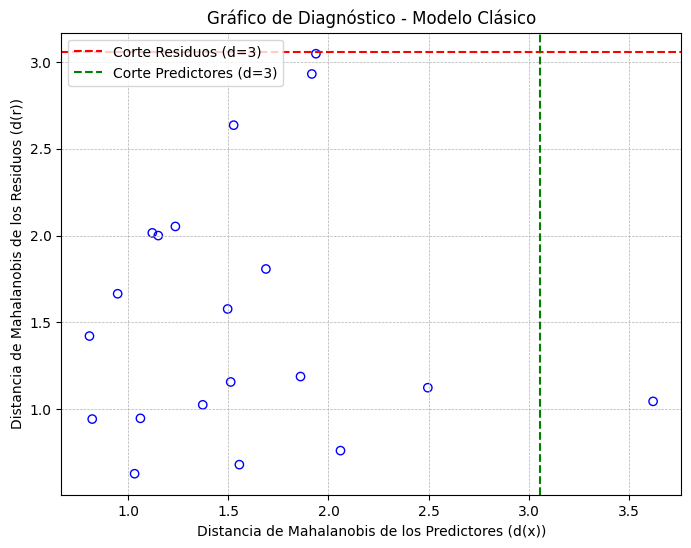


Tabla de Distancias - Modelo Reponderación LR (Final):
    d(x)  d(r_residuals)
0 1.3034          1.0958
1 1.5863          0.7767
2 2.9197          0.7754
3 1.4473          1.5351
4 0.9470          1.5041


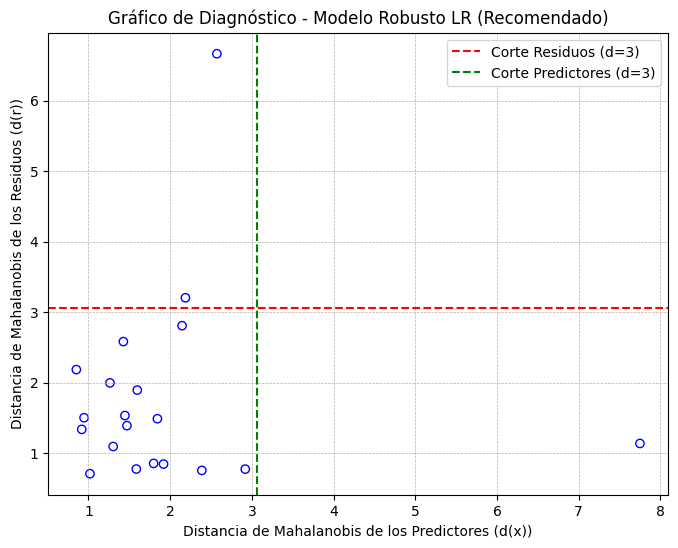



--- PARTE 4: SIMULACIÓN DE EFICIENCIA ---
Este proceso puede tardar varios minutos...

Tabla de Eficiencia (similar a Tabla 2, con gamma=0.25):
     Classical Slope Eff.  Classical Intercept Eff.  MCD Slope Eff.  \
n                                                                     
50                 0.8925                    0.9198          0.4164   
100                0.9215                    1.0006          0.6340   
300                0.9940                    0.9616          0.7778   

     MCD Intercept Eff.  L-Reweighted Slope Eff.  L-Reweighted Intercept Eff.  \
n                                                                               
50               0.6104                   0.4322                       0.6305   
100              0.7955                   0.6537                       0.8178   
300              0.8801                   0.7851                       0.8707   

     R-Reweighted Slope Eff.  R-Reweighted Intercept Eff.  \
n                              

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_linnerud
from sklearn.linear_model import LinearRegression
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

# --- PARTE 0: CARGA DE DATOS Y CONFIGURACIÓN ---
print("--- CARGANDO DATOS Y CONFIGURANDO ---")
# Cargar los datos linnerud (3 predictores, 3 respuestas)
X, y = load_linnerud(return_X_y=True)
predictor_names = ['Chins', 'Situps', 'Jumps']
response_names = ['Weight', 'Waist', 'Pulse']
p = X.shape[1]
q = y.shape[1]
n = X.shape[0]
print(f"Dataset cargado: {n} observaciones, {p} predictores, {q} respuestas.")

# --- PARTE 1: VISUALIZACIÓN 3D DE LOS DATOS CRUDOS ---
print("\n--- PARTE 1: VISUALIZACIÓN 3D DE LOS DATOS ---")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Graficamos 2 predictores y 1 respuesta para ver la relación
ax.scatter(X[:, 1], X[:, 2], y[:, 0], c='b', marker='o')
ax.set_xlabel(f'Predictor: {predictor_names[1]}')
ax.set_ylabel(f'Predictor: {predictor_names[2]}')
ax.set_zlabel(f'Respuesta: {response_names[0]}')
ax.set_title('Visualización 3D de los Datos Linnerud')
plt.show()

# --- PARTE 2: FUNCIONES AUXILIARES Y AJUSTE DE MODELOS ---
print("\n--- PARTE 2: AJUSTANDO LOS 5 MODELOS DE REGRESIÓN ---")

# --- Funciones auxiliares ---
def calculate_regression_from_components(mu_x, mu_y, Sigma_xx, Sigma_xy):
    """Calcula B y alpha a partir de los componentes de la media y covarianza."""
    B_hat = np.linalg.inv(Sigma_xx) @ Sigma_xy
    alpha_hat = mu_y - B_hat.T @ mu_x
    return B_hat, alpha_hat

def calculate_distances(X, y, B, alpha, Sigma_eps, mu_x, Sigma_xx):
    """Calcula las distancias de Mahalanobis para predictores y residuos."""
    # Distancia de los predictores (d(x_i))
    try:
        inv_Sigma_xx = np.linalg.inv(Sigma_xx)
        dist_x = np.array([np.sqrt(max(0, (xi - mu_x).T @ inv_Sigma_xx @ (xi - mu_x))) for xi in X])
    except np.linalg.LinAlgError:
        dist_x = np.full(n, np.nan)

    # Distancia de los residuos (d(r_i))
    residuals = y - (X @ B + alpha)
    try:
        inv_Sigma_eps = np.linalg.inv(Sigma_eps)
        dist_r = np.array([np.sqrt(max(0, r.T @ inv_Sigma_eps @ r)) for r in residuals])
    except np.linalg.LinAlgError:
        dist_r = np.full(n, np.nan)
        
    return dist_x, dist_r

def diagnostic_plot(dist_x, dist_r, title, p_dim, q_dim):
    """Genera el gráfico de diagnóstico d(r) vs d(x)."""
    cutoff_x = np.sqrt(chi2.ppf(0.975, df=p_dim))
    cutoff_r = np.sqrt(chi2.ppf(0.975, df=q_dim))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(dist_x, dist_r, facecolors='none', edgecolors='b')
    plt.axhline(cutoff_r, color='r', linestyle='--', label=f'Corte Residuos (d={q_dim})')
    plt.axvline(cutoff_x, color='g', linestyle='--', label=f'Corte Predictores (d={p_dim})')
    plt.xlabel('Distancia de Mahalanobis de los Predictores (d(x))')
    plt.ylabel('Distancia de Mahalanobis de los Residuos (d(r))')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# 1. Modelo Clásico
model_cls = LinearRegression().fit(X, y)
B_cls = model_cls.coef_.T
alpha_cls = model_cls.intercept_
res_cls = y - (X @ B_cls + alpha_cls)
Sigma_eps_cls = np.cov(res_cls.T)
mu_x_cls = np.mean(X, axis=0)
Sigma_xx_cls = np.cov(X.T)

# 2. Modelo MCD Puro
Z = np.hstack((X, y))
mcd = MinCovDet(support_fraction=0.75, random_state=42).fit(Z)
mu_mcd, Sigma_mcd = mcd.location_, mcd.covariance_
mu_x_mcd, mu_y_mcd = mu_mcd[:p], mu_mcd[p:]
S_xx_mcd, S_xy_mcd, S_yy_mcd = Sigma_mcd[:p, :p], Sigma_mcd[:p, p:], Sigma_mcd[p:, p:]
B_mcd, alpha_mcd = calculate_regression_from_components(mu_x_mcd, mu_y_mcd, S_xx_mcd, S_xy_mcd)
Sigma_eps_mcd = S_yy_mcd - S_xy_mcd.T @ np.linalg.inv(S_xx_mcd) @ S_xy_mcd

# 3. Modelo con Reponderación de Localización (L)
dist_loc = mcd.mahalanobis(Z)
cutoff_loc = chi2.ppf(0.975, df=p+q)
w_loc = (dist_loc < cutoff_loc).astype(int)
mu_L = np.average(Z, axis=0, weights=w_loc)
Sigma_L = np.cov(Z.T, aweights=w_loc)
mu_x_L, mu_y_L = mu_L[:p], mu_L[p:]
S_xx_L, S_xy_L, S_yy_L = Sigma_L[:p, :p], Sigma_L[:p, p:], Sigma_L[p:, p:]
B_L, alpha_L = calculate_regression_from_components(mu_x_L, mu_y_L, S_xx_L, S_xy_L)
Sigma_eps_L = S_yy_L - S_xy_L.T @ np.linalg.inv(S_xx_L) @ S_xy_L

# 4. Modelo con Reponderación de Regresión (R)
res_R = y - (X @ B_mcd + alpha_mcd)
dist_res_R = np.array([np.sqrt(max(0, r @ np.linalg.inv(Sigma_eps_mcd) @ r.T)) for r in res_R])
cutoff_res = chi2.ppf(0.975, df=q)
w_R = (dist_res_R < cutoff_res).astype(int)
model_R = LinearRegression().fit(X, y, sample_weight=w_R)
B_R = model_R.coef_.T
alpha_R = model_R.intercept_
res_R_final = y - (X @ B_R + alpha_R)
Sigma_eps_R = np.cov(res_R_final.T, aweights=w_R)

# 5. Modelo con Ambas Reponderaciones (LR)
res_LR = y - (X @ B_L + alpha_L)
dist_res_LR = np.array([np.sqrt(max(0, r @ np.linalg.inv(Sigma_eps_L) @ r.T)) for r in res_LR])
w_LR = (dist_res_LR < cutoff_res).astype(int)
model_LR = LinearRegression().fit(X, y, sample_weight=w_LR)
B_LR = model_LR.coef_.T
alpha_LR = model_LR.intercept_
res_LR_final = y - (X @ B_LR + alpha_LR)
Sigma_eps_LR = np.cov(res_LR_final.T, aweights=w_LR)

print("Modelos ajustados con éxito.")

# --- PARTE 3: DIAGNÓSTICOS DETALLADOS DE LOS MODELOS ---
print("\n--- PARTE 3: DIAGNÓSTICOS DE LOS MODELOS ---")
pd.options.display.float_format = '{:.4f}'.format

# 1. Diagnóstico Clásico
dx_cls, dr_cls = calculate_distances(X, y, B_cls, alpha_cls, Sigma_eps_cls, mu_x_cls, Sigma_xx_cls)
df_cls = pd.DataFrame({'d(x)': dx_cls, 'd(r_residuals)': dr_cls})
print("\nTabla de Distancias - Modelo Clásico:")
print(df_cls.head())
diagnostic_plot(dx_cls, dr_cls, 'Gráfico de Diagnóstico - Modelo Clásico', p, q)

# 2. Diagnóstico Reponderación LR (EL RECOMENDADO)
# Para d(x) robusto, usamos componentes L. Para d(r), usamos el modelo LR.
dx_LR, dr_LR = calculate_distances(X, y, B_LR, alpha_LR, Sigma_eps_LR, mu_x_L, S_xx_L)
df_LR = pd.DataFrame({'d(x)': dx_LR, 'd(r_residuals)': dr_LR})
print("\nTabla de Distancias - Modelo Reponderación LR (Final):")
print(df_LR.head())
diagnostic_plot(dx_LR, dr_LR, 'Gráfico de Diagnóstico - Modelo Robusto LR (Recomendado)', p, q)


# --- PARTE 4: SIMULACIÓN DE EFICIENCIA (REPLICANDO TABLA 2) ---
print("\n\n--- PARTE 4: SIMULACIÓN DE EFICIENCIA ---")
print("Este proceso puede tardar varios minutos...")

# Parámetros de la simulación
p_sim = 3
q_sim = 2
n_values = [50, 100, 300]
m_replications = 500 # Reducido de 1000 para que se ejecute más rápido
gamma_25_frac = 0.75 # Fracción de soporte para gamma = 0.25

results = []

for n_sim in n_values:
    # Contenedores para las estimaciones de cada replicación
    estimates = {
        'Classical': {'B': [], 'alpha': []},
        'MCD': {'B': [], 'alpha': []},
        'L-Reweighted': {'B': [], 'alpha': []},
        'R-Reweighted': {'B': [], 'alpha': []},
        'LR-Reweighted': {'B': [], 'alpha': []},
    }

    chi2_q_loc = chi2.ppf(0.975, df=p_sim+q_sim)
    chi2_q_res = chi2.ppf(0.975, df=q_sim)
    
    for _ in range(m_replications):
        X_sim = np.random.randn(n_sim, p_sim)
        y_sim = np.random.randn(n_sim, q_sim)
        Z_sim = np.hstack((X_sim, y_sim))

        # 1. Clásica
        model_cls_sim = LinearRegression().fit(X_sim, y_sim)
        estimates['Classical']['B'].append(model_cls_sim.coef_.T)
        estimates['Classical']['alpha'].append(model_cls_sim.intercept_)

        # --- Bloque Try-Except para robustez en la simulación ---
        try:
            # 2. MCD Puro
            mcd_sim = MinCovDet(support_fraction=gamma_25_frac).fit(Z_sim)
            mu_mcd_s, S_mcd_s = mcd_sim.location_, mcd_sim.covariance_
            mux_s, muy_s = mu_mcd_s[:p_sim], mu_mcd_s[p_sim:]
            Sxx_s, Sxy_s, Syy_s = S_mcd_s[:p_sim, :p_sim], S_mcd_s[:p_sim, p_sim:], S_mcd_s[p_sim:, p_sim:]
            B_mcd_s, alpha_mcd_s = calculate_regression_from_components(mux_s, muy_s, Sxx_s, Sxy_s)
            estimates['MCD']['B'].append(B_mcd_s)
            estimates['MCD']['alpha'].append(alpha_mcd_s)
            
            # 3. L-Reweighted
            dist_loc_s = mcd_sim.mahalanobis(Z_sim)
            w_loc_s = (dist_loc_s < chi2_q_loc).astype(int)
            if sum(w_loc_s) < p_sim + q_sim + 1: continue
            mu_L_s = np.average(Z_sim, axis=0, weights=w_loc_s)
            S_L_s = np.cov(Z_sim.T, aweights=w_loc_s)
            mux_L_s, muy_L_s = mu_L_s[:p_sim], mu_L_s[p_sim:]
            Sxx_L_s, Sxy_L_s, Syy_L_s = S_L_s[:p_sim, :p_sim], S_L_s[:p_sim, p_sim:], S_L_s[p_sim:, p_sim:]
            B_L_s, alpha_L_s = calculate_regression_from_components(mux_L_s, muy_L_s, Sxx_L_s, Sxy_L_s)
            estimates['L-Reweighted']['B'].append(B_L_s)
            estimates['L-Reweighted']['alpha'].append(alpha_L_s)
            
            # 4. R-Reweighted
            S_eps_mcd_s = Syy_s - Sxy_s.T @ np.linalg.inv(Sxx_s) @ Sxy_s
            inv_S_eps_s = np.linalg.inv(S_eps_mcd_s)
            res_R_s = y_sim - (X_sim @ B_mcd_s + alpha_mcd_s)
            dist_res_R_s = np.array([np.sqrt(max(0, r @ inv_S_eps_s @ r.T)) for r in res_R_s])
            w_R_s = (dist_res_R_s < chi2_q_res).astype(int)
            if sum(w_R_s) < p_sim + 1: continue
            model_R_s = LinearRegression().fit(X_sim, y_sim, sample_weight=w_R_s)
            estimates['R-Reweighted']['B'].append(model_R_s.coef_.T)
            estimates['R-Reweighted']['alpha'].append(model_R_s.intercept_)

            # 5. LR-Reweighted
            S_eps_L_s = Syy_L_s - Sxy_L_s.T @ np.linalg.inv(Sxx_L_s) @ Sxy_L_s
            inv_S_eps_L_s = np.linalg.inv(S_eps_L_s)
            res_LR_s = y_sim - (X_sim @ B_L_s + alpha_L_s)
            dist_res_LR_s = np.array([np.sqrt(max(0, r @ inv_S_eps_L_s @ r.T)) for r in res_LR_s])
            w_LR_s = (dist_res_LR_s < chi2_q_res).astype(int)
            if sum(w_LR_s) < p_sim + 1: continue
            model_LR_s = LinearRegression().fit(X_sim, y_sim, sample_weight=w_LR_s)
            estimates['LR-Reweighted']['B'].append(model_LR_s.coef_.T)
            estimates['LR-Reweighted']['alpha'].append(model_LR_s.intercept_)
        
        except np.linalg.LinAlgError:
            # Si una matriz es singular, saltamos esta replicación
            continue

    # Calcular varianzas y eficiencias para esta n
    row = {'n': n_sim}
    for method in estimates:
        var_B = n_sim * np.mean(np.var(np.array(estimates[method]['B']), axis=0))
        var_alpha = n_sim * np.mean(np.var(np.array(estimates[method]['alpha']), axis=0))
        row[f'{method} Slope Eff.'] = 1 / var_B if var_B > 0 else 0
        row[f'{method} Intercept Eff.'] = 1 / var_alpha if var_alpha > 0 else 0
    results.append(row)

# Crear y mostrar la tabla de resultados
df_results = pd.DataFrame(results).set_index('n')
print("\nTabla de Eficiencia (similar a Tabla 2, con gamma=0.25):")
print(df_results)

--- CARGANDO DATOS Y CONFIGURANDO ---
Dataset cargado: 20 observaciones, 3 predictores, 3 respuestas.

--- PARTE 1: VISUALIZACIÓN 3D DE LOS DATOS ---


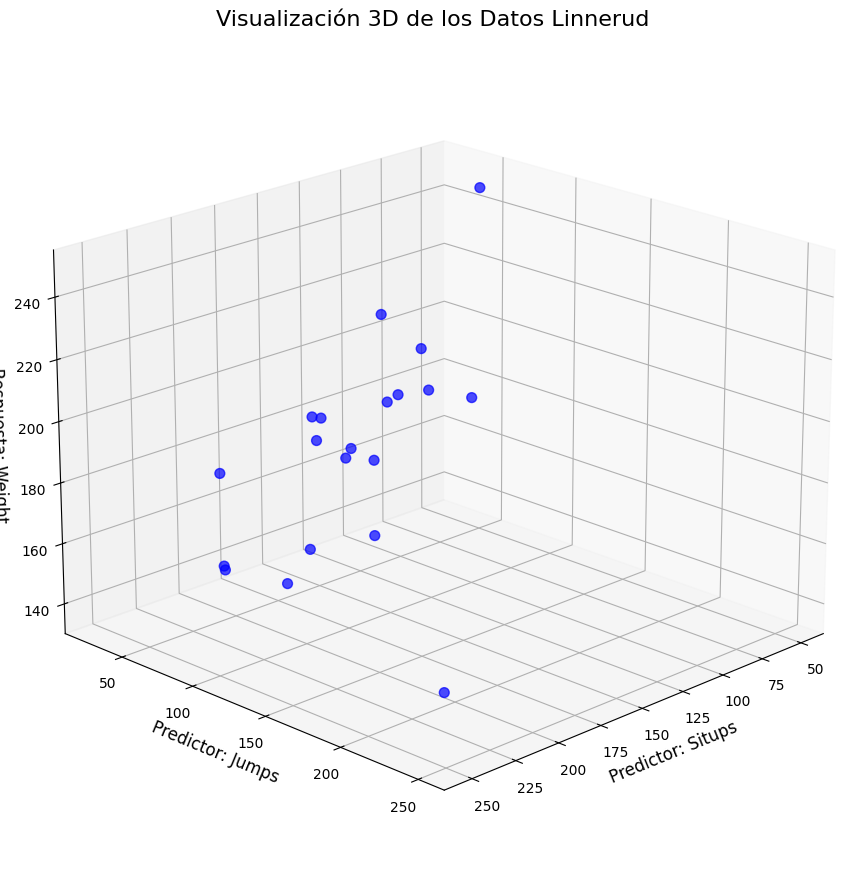


--- PARTE 2: AJUSTANDO LOS 5 MODELOS DE REGRESIÓN ---
Modelos ajustados con éxito.

--- PARTE 3: TABLA DE PARÁMETROS ESTIMADOS POR MODELO ---

==================== CLÁSICO ====================

Matriz de Pendientes B (B_hat):
        Weight   Waist   Pulse
Chins  -0.4750 -0.1369  0.0011
Situps -0.2177 -0.0403  0.0420
Jumps   0.0931  0.0280 -0.0295

Vector de Intercepto alpha (alpha_hat):
Weight   208.2335
Waist     40.5979
Pulse     52.0436
dtype: float64

Matriz de Covarianza de Errores (Sigma_eps_hat):
         Weight   Waist    Pulse
Weight 446.2919 39.1279 -41.4876
Waist   39.1279  4.6358  -3.6277
Pulse  -41.4876 -3.6277  48.0970

==================== MCD PURO ====================

Matriz de Pendientes B (B_hat):
        Weight   Waist   Pulse
Chins   0.0401 -0.0246 -0.2652
Situps -0.2175 -0.0339 -0.0083
Jumps   0.2355  0.0361  0.0529

Vector de Intercepto alpha (alpha_hat):
Weight   187.9439
Waist     37.6493
Pulse     55.2893
dtype: float64

Matriz de Covarianza de Errores (Sigm

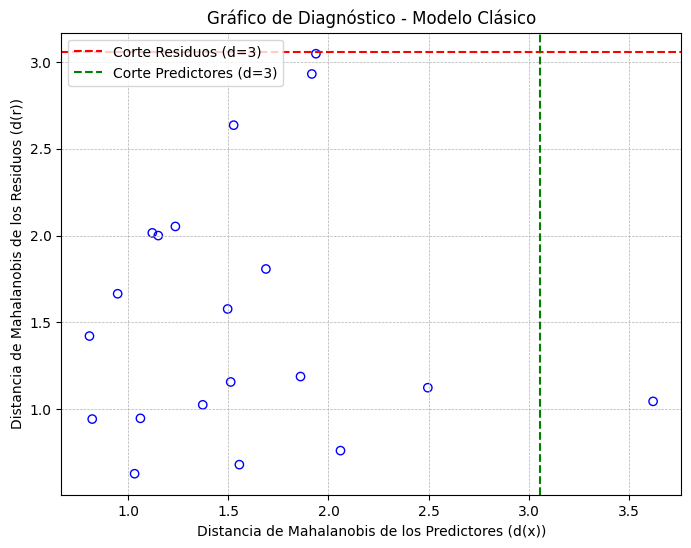


Tabla de Distancias - Modelo Reponderación LR (Final):
    d(x)  d(r_residuals)
0 1.3034          1.0958
1 1.5863          0.7767
2 2.9197          0.7754
3 1.4473          1.5351
4 0.9470          1.5041


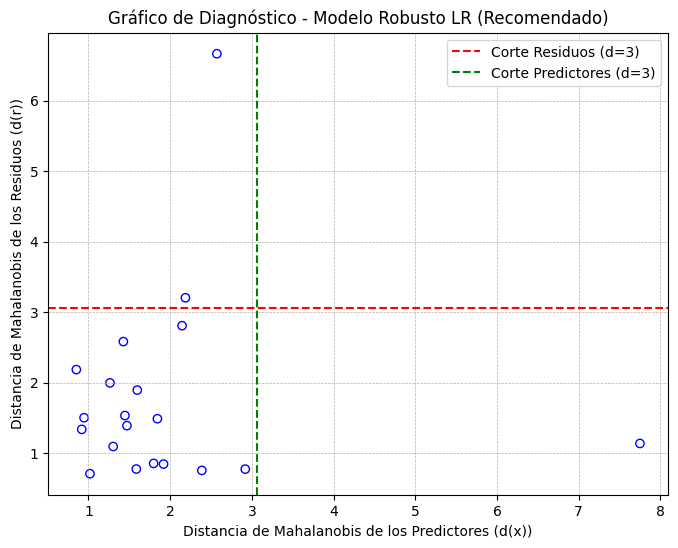



--- PARTE 5: SIMULACIÓN DE EFICIENCIA ---
Este proceso puede tardar varios minutos...

Tabla de Eficiencia (similar a Tabla 2, con gamma=0.25):
     Classical Slope Eff.  Classical Intercept Eff.  MCD Puro Slope Eff.  \
n                                                                          
50                 0.9239                    0.8650               0.4301   
100                0.9732                    1.0161               0.6313   
300                0.9928                    0.9917               0.7489   

     MCD Puro Intercept Eff.  Reponderación L Slope Eff.  \
n                                                          
50                    0.6173                      0.4430   
100                   0.8220                      0.6580   
300                   0.8836                      0.7606   

     Reponderación L Intercept Eff.  Reponderación R Slope Eff.  \
n                                                                 
50                           0.6261   

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_linnerud
from sklearn.linear_model import LinearRegression
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

# --- PARTE 0: CARGA DE DATOS Y CONFIGURACIÓN ---
print("--- CARGANDO DATOS Y CONFIGURANDO ---")
X, y = load_linnerud(return_X_y=True)
predictor_names = ['Chins', 'Situps', 'Jumps']
response_names = ['Weight', 'Waist', 'Pulse']
p = X.shape[1]
q = y.shape[1]
n = X.shape[0]
print(f"Dataset cargado: {n} observaciones, {p} predictores, {q} respuestas.")
# Configurar formato de pandas para mejor legibilidad
pd.options.display.float_format = '{:.4f}'.format

# --- PARTE 1: VISUALIZACIÓN 3D CORREGIDA ---
print("\n--- PARTE 1: VISUALIZACIÓN 3D DE LOS DATOS ---")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 1], X[:, 2], y[:, 0], c='b', marker='o', s=50, alpha=0.7)
ax.set_xlabel(f'Predictor: {predictor_names[1]}', fontsize=12)
ax.set_ylabel(f'Predictor: {predictor_names[2]}', fontsize=12)
ax.set_zlabel(f'Respuesta: {response_names[0]}', fontsize=12)
ax.set_title('Visualización 3D de los Datos Linnerud', fontsize=16)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

# --- PARTE 2: FUNCIONES AUXILIARES Y AJUSTE DE MODELOS ---
print("\n--- PARTE 2: AJUSTANDO LOS 5 MODELOS DE REGRESIÓN ---")

# --- Funciones auxiliares ---
def calculate_regression_from_components(mu_x, mu_y, Sigma_xx, Sigma_xy):
    """Calcula B y alpha a partir de los componentes de la media y covarianza."""
    B_hat = np.linalg.inv(Sigma_xx) @ Sigma_xy
    alpha_hat = mu_y - B_hat.T @ mu_x
    return B_hat, alpha_hat

def calculate_distances(X, y, B, alpha, Sigma_eps, mu_x, Sigma_xx):
    """Calcula las distancias de Mahalanobis para predictores y residuos."""
    try:
        inv_Sigma_xx = np.linalg.inv(Sigma_xx)
        dist_x = np.array([np.sqrt(max(0, (xi - mu_x).T @ inv_Sigma_xx @ (xi - mu_x))) for xi in X])
    except np.linalg.LinAlgError:
        dist_x = np.full(n, np.nan)
    residuals = y - (X @ B + alpha)
    try:
        inv_Sigma_eps = np.linalg.inv(Sigma_eps)
        dist_r = np.array([np.sqrt(max(0, r.T @ inv_Sigma_eps @ r)) for r in residuals])
    except np.linalg.LinAlgError:
        dist_r = np.full(n, np.nan)
    return dist_x, dist_r

def diagnostic_plot(dist_x, dist_r, title, p_dim, q_dim):
    """Genera el gráfico de diagnóstico d(r) vs d(x)."""
    cutoff_x = np.sqrt(chi2.ppf(0.975, df=p_dim))
    cutoff_r = np.sqrt(chi2.ppf(0.975, df=q_dim))
    plt.figure(figsize=(8, 6))
    plt.scatter(dist_x, dist_r, facecolors='none', edgecolors='b')
    plt.axhline(cutoff_r, color='r', linestyle='--', label=f'Corte Residuos (d={q_dim})')
    plt.axvline(cutoff_x, color='g', linestyle='--', label=f'Corte Predictores (d={p_dim})')
    plt.xlabel('Distancia de Mahalanobis de los Predictores (d(x))')
    plt.ylabel('Distancia de Mahalanobis de los Residuos (d(r))')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# --- Ajuste de los 5 modelos y almacenamiento de resultados ---
model_results = {}

# 1. Modelo Clásico
model_cls = LinearRegression().fit(X, y)
B_cls = model_cls.coef_.T
alpha_cls = model_cls.intercept_
res_cls = y - (X @ B_cls + alpha_cls)
Sigma_eps_cls = np.cov(res_cls.T)
model_results['Clásico'] = {'B': B_cls, 'alpha': alpha_cls, 'Sigma_eps': Sigma_eps_cls, 'mu_x': np.mean(X, axis=0), 'Sigma_xx': np.cov(X.T)}

# 2. Modelo MCD Puro
Z = np.hstack((X, y))
mcd = MinCovDet(support_fraction=0.75, random_state=42).fit(Z)
mu_mcd, Sigma_mcd = mcd.location_, mcd.covariance_
mu_x_mcd, mu_y_mcd = mu_mcd[:p], mu_mcd[p:]
S_xx_mcd, S_xy_mcd, S_yy_mcd = Sigma_mcd[:p, :p], Sigma_mcd[:p, p:], Sigma_mcd[p:, p:]
B_mcd, alpha_mcd = calculate_regression_from_components(mu_x_mcd, mu_y_mcd, S_xx_mcd, S_xy_mcd)
Sigma_eps_mcd = S_yy_mcd - S_xy_mcd.T @ np.linalg.inv(S_xx_mcd) @ S_xy_mcd
model_results['MCD Puro'] = {'B': B_mcd, 'alpha': alpha_mcd, 'Sigma_eps': Sigma_eps_mcd, 'mu_x': mu_x_mcd, 'Sigma_xx': S_xx_mcd}

# 3. Modelo Reponderación L
dist_loc = mcd.mahalanobis(Z)
cutoff_loc = chi2.ppf(0.975, df=p+q)
w_loc = (dist_loc < cutoff_loc).astype(int)
mu_L = np.average(Z, axis=0, weights=w_loc)
Sigma_L = np.cov(Z.T, aweights=w_loc)
mu_x_L, mu_y_L = mu_L[:p], mu_L[p:]
S_xx_L, S_xy_L, S_yy_L = Sigma_L[:p, :p], Sigma_L[:p, p:], Sigma_L[p:, p:]
B_L, alpha_L = calculate_regression_from_components(mu_x_L, mu_y_L, S_xx_L, S_xy_L)
Sigma_eps_L = S_yy_L - S_xy_L.T @ np.linalg.inv(S_xx_L) @ S_xy_L
model_results['Reponderación L'] = {'B': B_L, 'alpha': alpha_L, 'Sigma_eps': Sigma_eps_L, 'mu_x': mu_x_L, 'Sigma_xx': S_xx_L}

# 4. Modelo Reponderación R
res_R = y - (X @ B_mcd + alpha_mcd)
dist_res_R = np.array([np.sqrt(max(0, r @ np.linalg.inv(Sigma_eps_mcd) @ r.T)) for r in res_R])
cutoff_res = chi2.ppf(0.975, df=q)
w_R = (dist_res_R < cutoff_res).astype(int)
model_R = LinearRegression().fit(X, y, sample_weight=w_R)
B_R = model_R.coef_.T
alpha_R = model_R.intercept_
res_R_final = y - (X @ B_R + alpha_R)
Sigma_eps_R = np.cov(res_R_final.T, aweights=w_R)
model_results['Reponderación R'] = {'B': B_R, 'alpha': alpha_R, 'Sigma_eps': Sigma_eps_R, 'mu_x': mu_x_mcd, 'Sigma_xx': S_xx_mcd}

# 5. Modelo Reponderación LR
res_LR = y - (X @ B_L + alpha_L)
dist_res_LR = np.array([np.sqrt(max(0, r @ np.linalg.inv(Sigma_eps_L) @ r.T)) for r in res_LR])
w_LR = (dist_res_LR < cutoff_res).astype(int)
model_LR = LinearRegression().fit(X, y, sample_weight=w_LR)
B_LR = model_LR.coef_.T
alpha_LR = model_LR.intercept_
res_LR_final = y - (X @ B_LR + alpha_LR)
Sigma_eps_LR = np.cov(res_LR_final.T, aweights=w_LR)
model_results['Reponderación LR'] = {'B': B_LR, 'alpha': alpha_LR, 'Sigma_eps': Sigma_eps_LR, 'mu_x': mu_x_L, 'Sigma_xx': S_xx_L}

print("Modelos ajustados con éxito.")

# --- PARTE 3: TABLA CON PARÁMETROS ESTIMADOS ---
print("\n--- PARTE 3: TABLA DE PARÁMETROS ESTIMADOS POR MODELO ---")
for name, params in model_results.items():
    print(f"\n{'='*20} {name.upper()} {'='*20}")
    print("\nMatriz de Pendientes B (B_hat):")
    print(pd.DataFrame(params['B'], index=predictor_names, columns=response_names))
    print("\nVector de Intercepto alpha (alpha_hat):")
    print(pd.Series(params['alpha'], index=response_names))
    print("\nMatriz de Covarianza de Errores (Sigma_eps_hat):")
    print(pd.DataFrame(params['Sigma_eps'], index=response_names, columns=response_names))
print(f"\n{'='*62}")

# --- PARTE 4: DIAGNÓSTICOS DETALLADOS ---
print("\n--- PARTE 4: DIAGNÓSTICOS DETALLADOS DE LOS MODELOS ---")

# 1. Diagnóstico Clásico
params_cls = model_results['Clásico']
dx_cls, dr_cls = calculate_distances(X, y, params_cls['B'], params_cls['alpha'], params_cls['Sigma_eps'], params_cls['mu_x'], params_cls['Sigma_xx'])
df_cls = pd.DataFrame({'d(x)': dx_cls, 'd(r_residuals)': dr_cls})
print("\nTabla de Distancias - Modelo Clásico:")
print(df_cls.head())
diagnostic_plot(dx_cls, dr_cls, 'Gráfico de Diagnóstico - Modelo Clásico', p, q)

# 2. Diagnóstico Reponderación LR (EL RECOMENDADO)
params_lr = model_results['Reponderación LR']
dx_LR, dr_LR = calculate_distances(X, y, params_lr['B'], params_lr['alpha'], params_lr['Sigma_eps'], params_lr['mu_x'], params_lr['Sigma_xx'])
df_LR = pd.DataFrame({'d(x)': dx_LR, 'd(r_residuals)': dr_LR})
print("\nTabla de Distancias - Modelo Reponderación LR (Final):")
print(df_LR.head())
diagnostic_plot(dx_LR, dr_LR, 'Gráfico de Diagnóstico - Modelo Robusto LR (Recomendado)', p, q)

# --- PARTE 5: SIMULACIÓN DE EFICIENCIA (REPLICANDO TABLA 2) ---
print("\n\n--- PARTE 5: SIMULACIÓN DE EFICIENCIA ---")
print("Este proceso puede tardar varios minutos...")

# Parámetros de la simulación
p_sim = 3
q_sim = 2
n_values = [50, 100, 300]
m_replications = 500 # Reducido de 1000 para que se ejecute más rápido
gamma_25_frac = 0.75 # Fracción de soporte para gamma = 0.25
results = []

for n_sim in n_values:
    estimates = { 'Classical': {'B': [], 'alpha': []}, 'MCD Puro': {'B': [], 'alpha': []}, 'Reponderación L': {'B': [], 'alpha': []}, 'Reponderación R': {'B': [], 'alpha': []}, 'Reponderación LR': {'B': [], 'alpha': []} }
    chi2_q_loc = chi2.ppf(0.975, df=p_sim+q_sim)
    chi2_q_res = chi2.ppf(0.975, df=q_sim)
    
    for _ in range(m_replications):
        X_sim = np.random.randn(n_sim, p_sim)
        y_sim = np.random.randn(n_sim, q_sim)
        Z_sim = np.hstack((X_sim, y_sim))
        
        # 1. Clásica
        model_cls_sim = LinearRegression().fit(X_sim, y_sim)
        estimates['Classical']['B'].append(model_cls_sim.coef_.T)
        estimates['Classical']['alpha'].append(model_cls_sim.intercept_)

        try:
            # 2. MCD Puro
            mcd_sim = MinCovDet(support_fraction=gamma_25_frac).fit(Z_sim)
            mu_mcd_s, S_mcd_s = mcd_sim.location_, mcd_sim.covariance_
            mux_s, muy_s = mu_mcd_s[:p_sim], mu_mcd_s[p_sim:]
            Sxx_s, Sxy_s, Syy_s = S_mcd_s[:p_sim, :p_sim], S_mcd_s[:p_sim, p_sim:], S_mcd_s[p_sim:, p_sim:]
            B_mcd_s, alpha_mcd_s = calculate_regression_from_components(mux_s, muy_s, Sxx_s, Sxy_s)
            estimates['MCD Puro']['B'].append(B_mcd_s)
            estimates['MCD Puro']['alpha'].append(alpha_mcd_s)
            
            # 3. Reponderación L
            dist_loc_s = mcd_sim.mahalanobis(Z_sim)
            w_loc_s = (dist_loc_s < chi2_q_loc).astype(int)
            if sum(w_loc_s) < p_sim + q_sim + 1: continue
            mu_L_s = np.average(Z_sim, axis=0, weights=w_loc_s)
            S_L_s = np.cov(Z_sim.T, aweights=w_loc_s)
            mux_L_s, muy_L_s = mu_L_s[:p_sim], mu_L_s[p_sim:]
            Sxx_L_s, Sxy_L_s, Syy_L_s = S_L_s[:p_sim, :p_sim], S_L_s[:p_sim, p_sim:], S_L_s[p_sim:, p_sim:]
            B_L_s, alpha_L_s = calculate_regression_from_components(mux_L_s, muy_L_s, Sxx_L_s, Sxy_L_s)
            estimates['Reponderación L']['B'].append(B_L_s)
            estimates['Reponderación L']['alpha'].append(alpha_L_s)
            
            # 4. Reponderación R
            S_eps_mcd_s = Syy_s - Sxy_s.T @ np.linalg.inv(Sxx_s) @ Sxy_s
            inv_S_eps_s = np.linalg.inv(S_eps_mcd_s)
            res_R_s = y_sim - (X_sim @ B_mcd_s + alpha_mcd_s)
            dist_res_R_s = np.array([np.sqrt(max(0, r @ inv_S_eps_s @ r.T)) for r in res_R_s])
            w_R_s = (dist_res_R_s < chi2_q_res).astype(int)
            if sum(w_R_s) < p_sim + 1: continue
            model_R_s = LinearRegression().fit(X_sim, y_sim, sample_weight=w_R_s)
            estimates['Reponderación R']['B'].append(model_R_s.coef_.T)
            estimates['Reponderación R']['alpha'].append(model_R_s.intercept_)

            # 5. Reponderación LR
            S_eps_L_s = Syy_L_s - Sxy_L_s.T @ np.linalg.inv(Sxx_L_s) @ Sxy_L_s
            inv_S_eps_L_s = np.linalg.inv(S_eps_L_s)
            res_LR_s = y_sim - (X_sim @ B_L_s + alpha_L_s)
            dist_res_LR_s = np.array([np.sqrt(max(0, r @ inv_S_eps_L_s @ r.T)) for r in res_LR_s])
            w_LR_s = (dist_res_LR_s < chi2_q_res).astype(int)
            if sum(w_LR_s) < p_sim + 1: continue
            model_LR_s = LinearRegression().fit(X_sim, y_sim, sample_weight=w_LR_s)
            estimates['Reponderación LR']['B'].append(model_LR_s.coef_.T)
            estimates['Reponderación LR']['alpha'].append(model_LR_s.intercept_)
        
        except np.linalg.LinAlgError:
            continue

    row = {'n': n_sim}
    for method in estimates:
        var_B = n_sim * np.mean(np.var(np.array(estimates[method]['B']), axis=0))
        var_alpha = n_sim * np.mean(np.var(np.array(estimates[method]['alpha']), axis=0))
        row[f'{method} Slope Eff.'] = 1 / var_B if var_B > 0 else 0
        row[f'{method} Intercept Eff.'] = 1 / var_alpha if var_alpha > 0 else 0
    results.append(row)

df_results = pd.DataFrame(results).set_index('n')
print("\nTabla de Eficiencia (similar a Tabla 2, con gamma=0.25):")
print(df_results)